In [23]:
# Import necessary libraries. 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras as keras
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from ucimlrepo import fetch_ucirepo
from tensorflow.keras.regularizers import l2
import keras_tuner as kt

## Import the Obesity Dataset

In [ ]:
# Importing the dataset and data preview.
obesity_data = pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv", delimiter=",")

# Print the Table
obesity_data.head(15)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II
5,Male,29.0,1.62,53.0,no,yes,2.0,3.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Automobile,Normal_Weight
6,Female,23.0,1.50,55.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,0.0,Sometimes,Motorbike,Normal_Weight
7,Male,22.0,1.64,53.0,no,no,2.0,3.0,Sometimes,no,2.0,no,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
8,Male,24.0,1.78,64.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,1.0,Frequently,Public_Transportation,Normal_Weight
9,Male,22.0,1.72,68.0,yes,yes,2.0,3.0,Sometimes,no,2.0,no,1.0,1.0,no,Public_Transportation,Normal_Weight


## Check the datatype and convert them into correct datatype

In [3]:
# Display the data types of each column in the dataset
print(obesity_data.dtypes)

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object


In [4]:
# Convert FCVC and TUE to integers
X = obesity_data.drop(columns=['NObeyesdad']).copy()
X['FCVC'] = X['FCVC'].astype(int)
X['TUE'] = X['TUE'].astype(int)

# Separate target variable
y = obesity_data['NObeyesdad']

# Check the data types again
print(X.dtypes)

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                                int32
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                                 int32
CALC                               object
MTRANS                             object
dtype: object


## Split training, validation, and test dataset

In [5]:
# Split the data into 60% training, 20% validation, and 20% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42) 
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Standardize continuous features and encode categorical features

In [6]:
# Convert binary features from "yes"/"no" to 1/0 in the training, validation, and test sets
binary_features = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']

for feature in binary_features:
    X_train[feature] = X_train[feature].map({'yes': 1, 'no': 0})
    X_val[feature] = X_val[feature].map({'yes': 1, 'no': 0})
    X_test[feature] = X_test[feature].map({'yes': 1, 'no': 0})

# Sample columns based on data type
continuous_features = ['Age', 'Height', 'Weight', 'NCP', 'CH2O', 'FAF']
integer_features_to_encode = ['TUE', 'FCVC']  # Only apply OneHotEncoder to FCVC and TUE
categorical_features = ['Gender', 'CAEC', 'CALC', 'MTRANS']

# Define ColumnTransformer with the transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('continuous', StandardScaler(), continuous_features),  # Standardize continuous features
        ('binary', 'passthrough', binary_features),  # Binary features are already in 0/1 format
        ('integer_encode', OneHotEncoder(sparse_output=False), integer_features_to_encode),  # One-hot encode integer features
        ('categorical', OneHotEncoder(sparse_output=False), categorical_features)  # One-hot encode categorical features
    ])

# Fit the preprocessor only on the training data
X_train_transformed = preprocessor.fit_transform(X_train)

# Transform the validation and test sets using the preprocessor
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

# Check shapes to confirm transformations
print("Train shape:", X_train_transformed.shape)
print("Validation shape:", X_val_transformed.shape)
print("Test shape:", X_test_transformed.shape)


Train shape: (1266, 31)
Validation shape: (422, 31)
Test shape: (423, 31)


In [7]:
# Encode labels as integers
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

## Set up the model

In [19]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.optimizers import Adam

# Define the model (Using Selu activation for the input and hidden layers, he normalization kernel initializer, and softmax for the output layer)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='selu', input_shape=(31,), kernel_regularizer=l2(0.001),
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(32, activation='selu', kernel_regularizer=l2(0.001),
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(16, activation='selu', kernel_regularizer=l2(0.001),
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(7, activation='softmax')
])

# Compile the model (Use the Nadam optimizer)
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(X_train_transformed, y_train, 
                    epochs=200, 
                    batch_size=32, 
                    validation_data=(X_val_transformed, y_val))

Epoch 1/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1526 - loss: 5.8968 - val_accuracy: 0.2156 - val_loss: 2.4888
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1943 - loss: 4.0776 - val_accuracy: 0.3104 - val_loss: 2.0745
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1975 - loss: 3.6760 - val_accuracy: 0.3602 - val_loss: 1.8527
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2035 - loss: 3.2383 - val_accuracy: 0.3886 - val_loss: 1.7308
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2270 - loss: 3.0122 - val_accuracy: 0.3981 - val_loss: 1.6225
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2302 - loss: 2.7376 - val_accuracy: 0.3957 - val_loss: 1.5469
Epoch 7/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2879 - loss: 2.4493 - val_accuracy: 0.4455 - val_loss: 1.4795
Epoch 8/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2856 - loss: 2.3422 - val_accuracy: 0.4810 - v

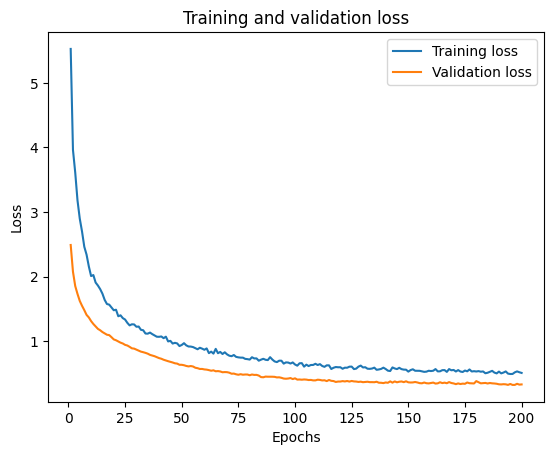

In [ ]:
# Plot of training and validation loss.
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss,  label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Check the Test accuracy

In [21]:
# Test
test_loss, test_accuracy = model.evaluate(X_test_transformed, y_test)

print("Test loss {:.4f}".format(test_loss))
print("Test accuracy {:.4f}".format(test_accuracy))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.9575 - loss: 0.3028
Test loss 0.3041
Test accuracy 0.9433


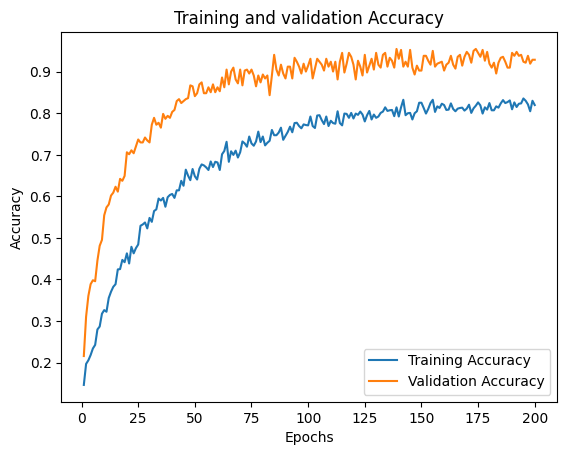

In [ ]:
# Plot of training and validation accuracy over epochs.

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, accuracy,  label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Hyperparameter Tuning

In [47]:
# Hyperparameter Tuning: How can we better optimize our FNN? Let us start with the basic model
# template with a custom function and test out different hyperparameters. 

def skeleton_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=10, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
    optimizer = hp.Choice("optimizer", values=["Adam", "RMSProp", "Nadam", "Adamax"])
    if optimizer == "Adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == "RMSProp":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, rho=0.9)
    elif optimizer == "Nadam":
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)
    
    samp_model = tf.keras.Sequential()
    samp_model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        samp_model.add(tf.keras.layers.Dense(n_neurons, activation="selu"))
    samp_model.add(tf.keras.layers.Dense(7, activation="softmax"))
    samp_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return samp_model

In [48]:
random_search_tuner = kt.RandomSearch(
    skeleton_model, objective="val_accuracy", max_trials=10, overwrite=True,
    seed=42)
random_search_tuner.search(X_train_transformed, y_train, epochs=5,
                           validation_data=(X_val_transformed, y_val))

Trial 10 Complete [00h 00m 09s]
val_accuracy: 0.8672986030578613

Best val_accuracy So Far: 0.9336493015289307
Total elapsed time: 00h 01m 26s


In [49]:
# After hyperparameter tuning trials, extract best hyperparameters from the RandomSearch tuner. 

best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 08 summary
Hyperparameters:
n_hidden: 9
n_neurons: 124
learning_rate: 0.0005509513888645584
optimizer: Adamax
Score: 0.9336493015289307


## Set up the alternative model using optimized hyperparameters

In [54]:
# Now we rerun the alternative model using the optimized hyperparameters. 

model = tf.keras.Sequential([
    tf.keras.layers.Dense(124, activation='selu', input_shape=(31,), kernel_regularizer=l2(0.001),
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(124, activation='selu', kernel_regularizer=l2(0.001),
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(64, activation='selu', kernel_regularizer=l2(0.001),
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(32, activation='selu', kernel_regularizer=l2(0.001),
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(16, activation='selu', kernel_regularizer=l2(0.001),
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(7, activation='softmax')
])

# Compile the final model.
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.0005509513888645584), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(X_train_transformed, y_train, 
                    epochs=200, 
                    batch_size=32, 
                    validation_data=(X_val_transformed, y_val))

Epoch 1/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.1348 - loss: 9.4080 - val_accuracy: 0.2678 - val_loss: 3.0923
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1621 - loss: 7.3696 - val_accuracy: 0.3081 - val_loss: 2.9181
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1337 - loss: 7.0938 - val_accuracy: 0.3175 - val_loss: 2.7987
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1567 - loss: 5.9928 - val_accuracy: 0.3081 - val_loss: 2.7337
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1787 - loss: 5.8552 - val_accuracy: 0.3152 - val_loss: 2.7066
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1585 - loss: 5.3175 - val_accuracy: 0.3009 - val_loss: 2.7017
Epoch 7/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1930 - loss: 4.7836 - val_accuracy: 0.3128 - val_loss: 2.6871
Epoch 8/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1809 - loss: 4.5549 - val_accuracy: 0.3199 - 

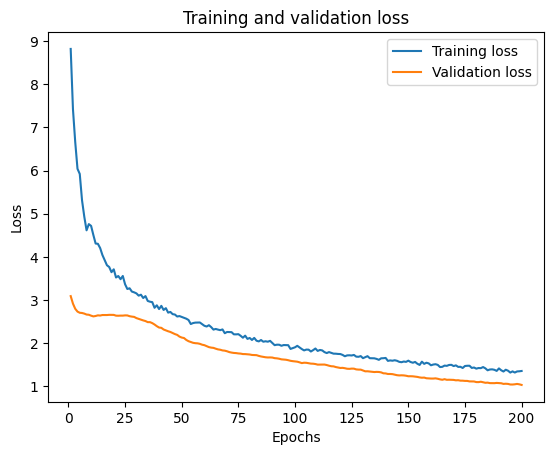

In [55]:
# Plot of training and validation loss of the final model. 

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss,  label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Check the test accuracy for the alternative model

In [56]:
# Test accuracy and loss for the final model.

test_loss, test_accuracy = model.evaluate(X_test_transformed, y_test)

print("Test loss {:.4f}".format(test_loss))
print("Test accuracy {:.4f}".format(test_accuracy))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8918 - loss: 1.0025 
Test loss 0.9870
Test accuracy 0.9031


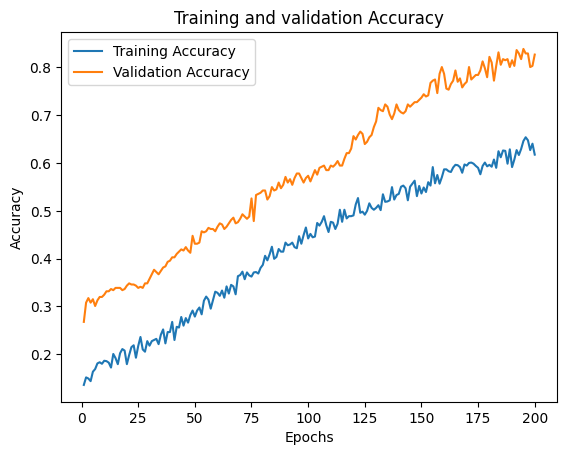

In [57]:
# Plot of training and validation accuracy over epochs for the final model.

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, accuracy,  label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Even with hyperparameter tuning, our original model yielded a better test accuracy and test loss overall, hence we will use it as our true final model. (94.33% is the best we could do even with hyperparameter tuning).